Randomly picking an image from the CIFAR-10 test_batch

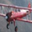

In [1]:
import pickle
import numpy as np
from PIL import Image
import random

# Load the CIFAR-10 test_batch file
with open('CIFAR_test_batch', 'rb') as file:
    test_batch = pickle.load(file, encoding='bytes')

# Extract images and labels from the test_batch
images = test_batch[b'data']
labels = test_batch[b'labels']

# CIFAR-10 classes
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Randomly select an image
index = random.randint(0, len(images) - 1)
image_array = images[index]
label = labels[index]

# Reshape the image for visualization and create a PIL image from the array
image_array = image_array.reshape(3, 32, 32).transpose(1, 2, 0)

image = Image.fromarray(image_array)

image


Using the pre-trained model : vit-base-patch16-224-cifar10 on the test batch of CIFAR-10

Predicted class: airplane


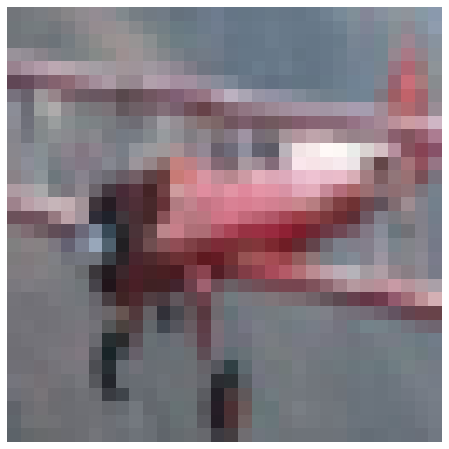

In [3]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the feature extractor and model from the Hugging Face Model Hub
feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')

# Prepare the image for the model and get the predicted class index
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# Map the predicted class index to the CIFAR-10 classes
predicted_class = cifar10_classes[predicted_class_idx]
print("Predicted class:", predicted_class)

# Let's zoom into the picture
plt.figure(figsize=(8, 8))  # Adjust the size if needed
plt.imshow(image)
plt.axis('off') 
plt.show()


* The paper shows that a pure transformer applied to sequences of image patches can achieve excellent results on various image classification benchmark datasets.

* This approach is particularly significant because it suggests that the reliance on CNNs for image recognition tasks is not strictly necessary and that Transformers can serve as a powerful alternative.

The pre-trained model "vit-base-patch16-224-cifar10" processes images by splitting them into fixed-size patches of 16x16 pixels. 

Since the model is designed to work with images of resolution 224x224 pixels, we will first resize the image picked from the CIFAR-10 dataset (which is 32x32 pixels).

Then it would divide the image into 196 (14 x 14) patches of 16 pixels each  (224/16 = 14)

Here's what's happening behind the scenes:

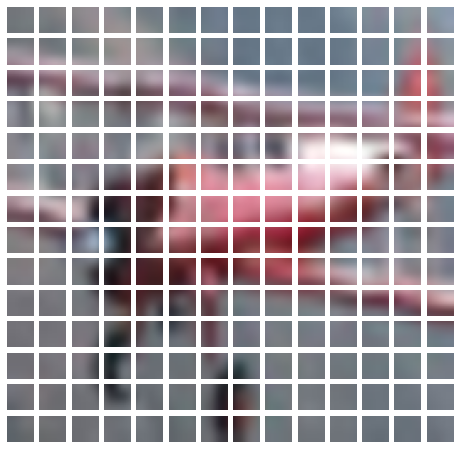

In [4]:
import numpy as np
import matplotlib.pyplot as plt

resized_image = image.resize((224, 224))

image_array = np.array(resized_image)

patch_size = 16  # 16x16 pixels per patch
patches_per_dim = 224 // patch_size  # 14 patches per dimension


patches = []

# Split the resized image into 14x14 patches
for i in range(0, patches_per_dim):
    for j in range(0, patches_per_dim):
        # Extract the patch
        patch = image_array[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
        patches.append(patch)

# Visualize the patches in sequence
fig, axes = plt.subplots(patches_per_dim, patches_per_dim, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(patches[i].astype('uint8'))
    ax.axis('off')

plt.show()


Then we flatten each 2D patch into a 1D vector

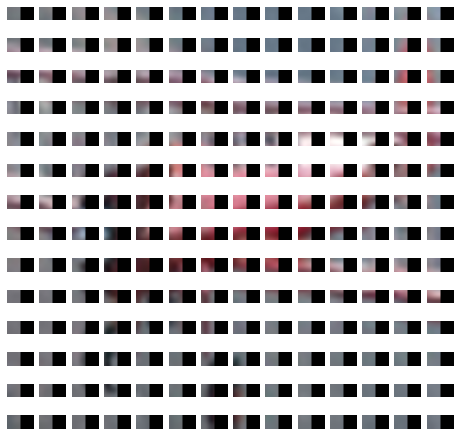

In [5]:

# Initialize an empty list to hold the flattened patches
flattened_patches = []

# Split the resized image into 14x14 patches and flatten them
for i in range(0, patches_per_dim):
    for j in range(0, patches_per_dim):
        
        patch = image_array[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]
        
        flattened_patch = patch.flatten()
        flattened_patches.append(flattened_patch)


# For visualization purposes, we'll create a dummy array of ones to represent the positional embeddings
positional_embeddings = np.ones_like(flattened_patches)

# Visualize the flattened patches with their corresponding positional embeddings
fig, axes = plt.subplots(patches_per_dim, patches_per_dim, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    
    # We'll display the patch and its positional embedding side by side to match the diagram in the paper
    ax.imshow(np.hstack((flattened_patches[i].reshape(patch_size, patch_size, 3), positional_embeddings[i].reshape(patch_size, patch_size, 3).astype('uint8'))))
    ax.axis('off')

plt.show()


While we cannot visualize positional embeddings as images, we can think of them as a set of coordinates or markers that tell the model “this patch is from the top-left corner,” “this one is from the middle,” and so on. This positional information allows the model to make sense of the image as a whole and understand the spatial relationships between different parts of the image.

You will see a black square because the dummy representation used in the visualization is not meaningful. 

The actual positional embeddings would be numerical vectors that are not meant to be displayed as images.  
Their purpose is to be combined mathematically with the patch embeddings before being processed by the Transformer encoder.

![alternatvie text](./Vit.png)

#### Let's experiment with a different dataset, CINIC-10 which has the exact same classes as CIFAR-10

https://datashare.ed.ac.uk/handle/10283/3192


Accuracy: 0.8918
Precision: 0.8913
Recall: 0.8918
F1 Score: 0.8913


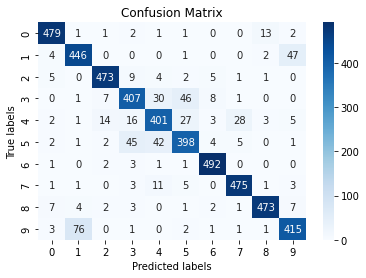

In [7]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Path to the CINIC-10 dataset. I have downloaded the test_set locally
cinic_directory = './CINIC_test_batch/'

# CIFAR-10 classes : Same as CINIC-10
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Define the transformations for the dataset. Our pre-trained model will need it to be 224 x 224
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the CINIC-10 test dataset and set number of images to pick from each class
test_dataset = datasets.ImageFolder(cinic_directory, transform=transform)

num_images_per_class = 500

# Create a dictionary to hold indices for each class and populating the dictionary
class_indices = {class_name: [] for class_name in cifar10_classes}

for idx, (_, label) in enumerate(test_dataset):
    class_name = cifar10_classes[label]
    class_indices[class_name].append(idx)


# Randomly select indices from each class
selected_indices = []

for class_name, indices in class_indices.items():
    if len(indices) >= num_images_per_class:
        selected_indices.extend(np.random.choice(indices, num_images_per_class, replace=False))
    else:
        selected_indices.extend(indices)

# Create a DataLoader with the SubsetRandomSampler
sampler = SubsetRandomSampler(selected_indices)
test_loader = DataLoader(test_dataset, batch_size=64, sampler=sampler, shuffle=False)

# Using our pre-trained CIFAR-10 model described above
feature_extractor = ViTFeatureExtractor.from_pretrained('nateraw/vit-base-patch16-224-cifar10', do_rescale=False)
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10')

# Move the model to the GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


true_labels = []
predicted_labels = []

# Evaluate the model
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        # Prepare the images for the model
        inputs = feature_extractor(images=images, return_tensors="pt")
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(**inputs)
        _, predicted_class_idx = torch.max(outputs.logits, 1)
         
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted_class_idx.cpu().numpy())

# Get the metrics and confusion matrix
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()